In [1]:
import pandas as pd
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import dropout_adj, to_dense_adj, dense_to_sparse, to_undirected, add_self_loops
from torch_geometric.nn import SAGEConv, GraphConv
import torch_geometric.transforms as T
from torch.utils.data import Dataset, DataLoader

In [3]:
airport = pd.read_csv('airport_adj_matrix.csv', index_col=0)
border = pd.read_csv('border_adj_matrix.csv', index_col=0)
cases_and_exogenous = pd.read_csv('cases_and_exogenous_il.csv')
combined_prevalence_and_exogenous = pd.read_csv('combined_prevalence_and_exogenous.csv')
highway_adj_matrix = pd.read_csv('highway_adj_matrix.csv', index_col=0)
r0 = pd.read_csv('r0.csv', index_col=0)
combined_covariates_interpolated = pd.read_csv('combined_covariates_interpolated.csv')
pivoted_prevalences = pd.read_csv('pivoted_prevalences.csv')

In [4]:
vals = border.to_numpy(dtype=float)
mask = vals != 0

if mask.any():
    vmin = vals[mask].min()
    vmax = vals[mask].max()
    if vmax > vmin:
        vals[mask] = (vals[mask] - vmin) / (vmax - vmin)
    else:
        # all nonzeros are equal → map them to 1
        vals[mask] = 1.0

border_scaled = pd.DataFrame(vals, index=border.index, columns=border.columns)

In [5]:
VARIANTS  = ['Alpha', 'Delta', 'Epsilon', 'Iota']
df = combined_prevalence_and_exogenous.copy()
df = df.sort_values(['location', 'date'])

non_key = [c for c in df.columns if c not in ['location', 'date']]
df[non_key] = df.groupby('location', group_keys=False)[non_key].ffill().bfill()

# Rebase the index to 0..n-1
df = df.reset_index(drop=True)

combined_prevalence_and_exogenous = df
combined_prevalence_and_exogenous['Others'] = 1 - combined_prevalence_and_exogenous[VARIANTS].sum(axis=1)

In [6]:
mobility = airport + highway_adj_matrix + border_scaled

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
FEATURE_COLS = ['cases_pc_7d','deaths_pc_7d']  # put your daily node features here (created below)
VARIANTS      = ['Alpha', 'Beta', 'Delta', 'Epsilon', 'Gamma', 'Iota', 'Omicron']  # edit to your columns
R0_DICT       = {'Alpha': 1.19, 'Beta': 1.15, 'Gamma': 1.21, 'Delta': 1.17, 'Epsilon':1.12, 'Iota':1.16, 'Omicron': 1.53}
T_IN          = 28
HORIZON       = 1
EPOCHS        = 50
LR            = 1e-3
BATCH_SIZE    = 1
TRAIN_RATIO   = 0.7
VAL_RATIO     = 0.1
PER_CAPITA    = None
SMOOTH_DAYS   = 7      # rolling mean window for stability

In [34]:
df = combined_covariates_interpolated.copy()
df = df.sort_values(['location', 'date']).reset_index(drop=True)

# Columns to treat specially
special = [c for c in ['confirmed', 'deaths', 'people_vaccinated', 'people_fully_vaccinated'] if c in df.columns]
non_key = [c for c in df.columns if c not in ['location', 'date']]
others = [c for c in non_key if c not in special]

# 1) ffill/bfill for non-special columns
if others:
    df[others] = (
        df.groupby('location', group_keys=False)[others]
          .ffill().bfill()
    )

# 2) linear interpolation for cumulative columns (confirmed, deaths)
if special:
    # ensure numeric
    df[special] = df[special].apply(pd.to_numeric, errors='coerce')

    df[special] = (
        df.groupby('location', group_keys=False)[special]
          .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))
    )

    # (Optional) enforce monotonic non-decreasing per location
    df[special] = (
     df.groupby('location', group_keys=False)[special]
           .apply(lambda g: g.clip(lower=g.cummax()))
     )

combined_covariates_interpolated = df

# Recompute 'Others' share if you have VARIANTS columns
combined_covariates_interpolated['Others'] = (
    1 - combined_covariates_interpolated[VARIANTS].sum(axis=1)
)

In [10]:
def build_graph_from_adj(adj_df: pd.DataFrame, county_names: list = None, undirected=True, add_loops=True):
    A = torch.tensor(adj_df.values, dtype=torch.float32)
    
    # remove self entries; we will add later
    A.fill_diagonal_(0.)
    edge_index, edge_weight = dense_to_sparse(A)  # mobility as weights
    if undirected:
        edge_index, edge_weight = to_undirected(edge_index, edge_weight, reduce='mean')
    if add_loops:
        edge_index, edge_weight = add_self_loops(edge_index, edge_weight, num_nodes=A.size(0), fill_value=1.0)
    data = Data(edge_index=edge_index, edge_weight=edge_weight, num_nodes=A.size(0))
    data.county_names = county_names
    return data

In [42]:
def build_XY(
    df: pd.DataFrame,
    county_names: list,
    variant_cols: list,           # e.g. ['alpha','beta','gamma','delta','omicron']
    r0_dict: dict = None,         # kept for API compatibility; ignored
    feature_cols_out: list = None,# e.g. ['cases_pc_7d','deaths_pc_7d','mobility_in', ...]
    county_col='location',
    date_col='date',
    confirmed_col='confirmed',
    death_col='deaths',
    pop_col='population',
    per_capita=1e5,               # None to keep raw counts
    smooth_days=7,                # rolling mean window
    fill_method='ffill_then_zero',# 'ffill_then_zero' | 'ffill' | 'zero' | None
    renormalize_variant_shares=True,
    verbose=False
):
    """
    Returns:
      X_all: [T, N, F]   using exactly `feature_cols_out` (no r0_wavg)
      Y_all: [T, N, K]   per-variant incidence (per-capita, smoothed)
      dates: DatetimeIndex of length T
    """
    if feature_cols_out is None:
        feature_cols_out = []

    d = df.copy()

    # --- normalize keys ---
    d[county_col] = d[county_col].astype(str).str.strip()
    d[date_col]   = pd.to_datetime(d[date_col]).dt.normalize()
    d = d[d[county_col].isin(set(county_names))]
    d = d.sort_values([county_col, date_col])
    if d.empty:
        raise ValueError("No rows after filtering to county_names. Check names/casing.")

    # --- ensure variant columns exist; coerce numeric and clip to [0,1] ---
    for v in variant_cols:
        if v not in d.columns:
            if verbose: print(f"[WARN] missing variant column '{v}', filling with 0.")
            d[v] = 0.0
    if variant_cols:
        d[variant_cols] = d[variant_cols].apply(pd.to_numeric, errors='coerce').clip(0.0, 1.0)
        if renormalize_variant_shares:
            share_sum = d[variant_cols].sum(axis=1)
            mask = share_sum > 0
            d.loc[mask, variant_cols] = d.loc[mask, variant_cols].div(share_sum[mask], axis=0)
            # rows with all-zeros stay zeros (unknown/none)

    # --- daily new cases/deaths from cumulative ---
    d['new_cases']  = d.groupby(county_col)[confirmed_col].diff().clip(lower=0).fillna(0)
    if death_col in d.columns:
        d['new_deaths'] = d.groupby(county_col)[death_col].diff().clip(lower=0).fillna(0)
    else:
        d['new_deaths'] = 0.0

    # --- per-capita scaling ---
    if (pop_col in d.columns) and (per_capita is not None):
        denom = d[pop_col].replace(0, np.nan)
        d['cases_pc']  = per_capita * d['new_cases']  / denom
        d['deaths_pc'] = per_capita * d['new_deaths'] / denom
    else:
        d['cases_pc']  = d['new_cases']
        d['deaths_pc'] = d['new_deaths']

    # --- smoothing ---
    if smooth_days and smooth_days > 1:
        for col in ['cases_pc', 'deaths_pc']:
            d[f'{col}_7d'] = (
                d.groupby(county_col)[col]
                 .rolling(smooth_days, min_periods=1).mean()
                 .reset_index(level=0, drop=True)
            )
    else:
        d['cases_pc_7d']  = d['cases_pc']
        d['deaths_pc_7d'] = d['deaths_pc']

    # --- fill strategy BEFORE pivoting (reduce NaNs) ---
    feature_cols = list(feature_cols_out)  # EXACT features for X
    cols_to_fill = list(set(feature_cols + ['cases_pc_7d']))
    cols_to_fill = [c for c in cols_to_fill if c in d.columns]
    if fill_method in ('ffill', 'ffill_then_zero'):
        d[cols_to_fill] = d.groupby(county_col)[cols_to_fill].ffill()
        if fill_method == 'ffill_then_zero':
            d[cols_to_fill] = d[cols_to_fill].fillna(0.0)
    elif fill_method == 'zero':
        d[cols_to_fill] = d[cols_to_fill].fillna(0.0)

    # --- timeline & pivot helper ---
    dates = np.sort(d[date_col].unique())
    if len(dates) == 0:
        raise ValueError("No dates after normalization.")

    def pivot_TN(col):
        if col not in d.columns:
            if verbose: print(f"[WARN] missing {col}, filling zeros.")
            return np.zeros((len(dates), len(county_names)), dtype='float32')
        wide = (
            d.pivot_table(index=county_col, columns=date_col, values=col, aggfunc='mean')
             .reindex(index=county_names, columns=dates)
        ).fillna(0.0)
        return wide.values.T.astype('float32')   # [T, N]

    # --- X: stack ONLY requested features ---
    X_all = torch.tensor(
        np.stack([pivot_TN(c) for c in feature_cols], axis=-1) if feature_cols else
        np.zeros((len(dates), len(county_names), 0), dtype='float32'),
        dtype=torch.float32
    )  # [T,N,F]

    # --- Y: per-variant incidence (per-capita, smoothed) = cases_pc_7d * share_v ---
    for v in variant_cols:
        d[f'{v}_incidence_pc_7d'] = d['cases_pc_7d'].fillna(0.0) * d[v].fillna(0.0)

    Y_stack = np.stack([pivot_TN(f'{v}_incidence_pc_7d') for v in variant_cols], axis=-1)  # [T,N,K]
    Y_all = torch.tensor(Y_stack, dtype=torch.float32)

    if verbose:
        T, N, F = X_all.shape
        _, _, K = Y_all.shape
        print(f"[OK] X_all: (T={T}, N={N}, F={F}); Y_all: (T={T}, N={N}, K={K})")
        nnzX = (X_all != 0).float().mean().item() if F > 0 else 0.0
        nnzY = (Y_all != 0).float().mean().item()
        print(f"      nnz frac X={nnzX:.3f}, Y={nnzY:.3f}")

    return X_all, Y_all, pd.to_datetime(dates)


In [43]:
county_names = mobility.columns.tolist()
data = build_graph_from_adj(mobility, county_names, undirected=True, add_loops=True)

X_all, Y_all, dates = build_XY(
     combined_covariates_interpolated, county_names,
     variant_cols=VARIANTS,r0_dict = R0_DICT ,
     feature_cols_out=FEATURE_COLS,
     county_col='location', date_col='date',
     confirmed_col='confirmed', death_col='deaths', pop_col='population',
     per_capita=None, smooth_days=None
 )

r0_vec = [R0_DICT[v] for v in VARIANTS]

In [13]:
def make_windows(X_all, Y_all, L=28, horizon=1):
    # X_all: [T,N,F], Y_all: [T,N,K]
    Xs, Ys = [], []
    for t in range(L, len(X_all) - horizon + 1):
        Xs.append(X_all[t-L:t])                # [L,N,F]
        Ys.append(Y_all[t + horizon - 1])      # [N,K] (predict next step)
    # -> [B,L,N,F], [B,N,K]
    return np.stack(Xs), np.stack(Ys)

In [64]:
L = 28
horizon = 1

Xs, Ys = make_windows(X_all, Y_all, L=L, horizon=horizon)

# Determine how many windows for training vs testing
train_frac = 0.8  # 80% train, 20% test
n_total = len(Xs)
n_train = int(n_total * train_frac)

# Split
X_train, Y_train = Xs[:n_train], Ys[:n_train]
X_test,  Y_test  = Xs[n_train:], Ys[n_train:]

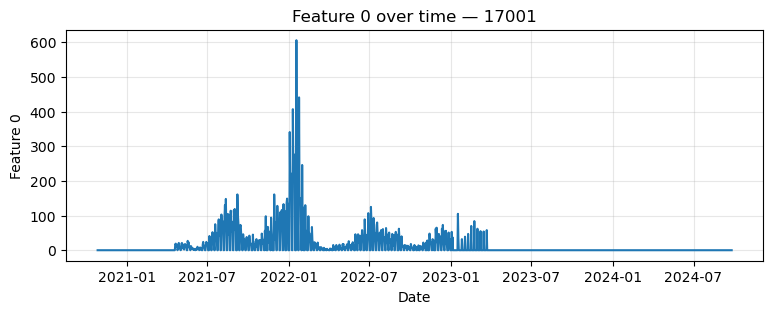

In [48]:
import matplotlib.pyplot as plt

county0 = county_names[0]  # name of the first county, if you have this list
y = X_all[:, 0, 0].detach().cpu().numpy()

plt.figure(figsize=(9,3))
plt.plot(dates, y)
plt.title(f"Feature 0 over time — {county0}")
plt.xlabel("Date"); plt.ylabel("Feature 0"); plt.grid(True, alpha=0.3)
plt.show()

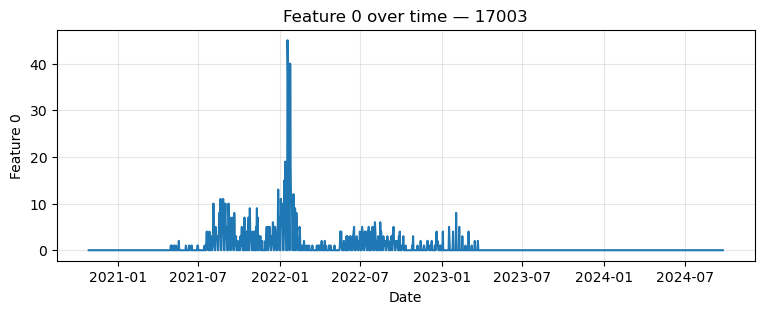

In [49]:
county0 = county_names[1]  # name of the first county, if you have this list
y = X_all[:, 1, 0].detach().cpu().numpy()

plt.figure(figsize=(9,3))
plt.plot(dates, y)
plt.title(f"Feature 0 over time — {county0}")
plt.xlabel("Date"); plt.ylabel("Feature 0"); plt.grid(True, alpha=0.3)
plt.show()

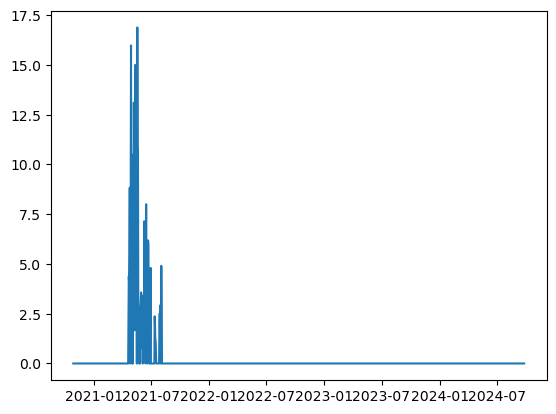

In [60]:
plt.plot(dates, Y_all[:,0,0])

In [32]:
cut = pd.Timestamp('2023-03-24')

# make sure dates is a pandas DatetimeIndex
dates = pd.to_datetime(dates)

# time mask
tmask = dates >= cut                       # [T]

# slice feature 0 over the time window: [T_sel, N]
X_sel = X_all[tmask, :, 0]

# counties with ANY nonzero entries after 2023-07
nonzero_mask = (X_sel != 0).any(dim=0)     # [N] boolean

# indices u
u_idx = nonzero_mask.nonzero(as_tuple=True)[0].cpu().numpy().tolist()

# names for readability
u_names = [county_names[i] for i in u_idx]

print("Indices:", u_idx)
print("Counties:", u_names)

# (optional) how many nonzero time-steps per county in that window
nonzero_counts = (X_sel != 0).sum(dim=0).cpu().numpy()
for i in u_idx[:10]:  # show first 10
    print(county_names[i], int(nonzero_counts[i]))

Indices: []
Counties: []


In [33]:
cut = pd.Timestamp('2023-03-24')

# make sure dates is a pandas DatetimeIndex
dates = pd.to_datetime(dates)

# time mask
tmask = dates >= cut                       # [T]

# slice feature 0 over the time window: [T_sel, N]
Y_sel = Y_all[tmask, :, 0]

# counties with ANY nonzero entries after 2023-07
nonzero_mask = (Y_sel != 0).any(dim=0)     # [N] boolean

# indices u
u_idx = nonzero_mask.nonzero(as_tuple=True)[0].cpu().numpy().tolist()

# names for readability
u_names = [county_names[i] for i in u_idx]

print("Indices:", u_idx)
print("Counties:", u_names)

# (optional) how many nonzero time-steps per county in that window
nonzero_counts = (Y_sel != 0).sum(dim=0).cpu().numpy()
for i in u_idx[:10]:  # show first 10
    print(county_names[i], int(nonzero_counts[i]))

Indices: []
Counties: []


In [61]:
"""
class STGCN_Hurdle_K(nn.Module):
    def __init__(self, in_f, hid_f=64, K=3, cheb_K=3, n_blocks=2):
        super().__init__()
        self.blocks = nn.ModuleList([
            STGCNBlock(in_f if i==0 else hid_f, hid_f, K=cheb_K, t_kernel=3, t_dilation=2**i)
            for i in range(n_blocks)
        ])
        # Heads: map hidden -> K parameters per node
        self.head_p  = nn.Linear(hid_f, K)   # sigmoid → [B,N,K]
        self.head_mu = nn.Linear(hid_f, K)   # softplus → [B,N,K]
        self.head_r  = nn.Linear(hid_f, K)   # softplus → [B,N,K]

    def forward(self, X, edge_index, edge_weight=None):
        # X: [B,T,N,F]
        H = X
        for b in self.blocks:
            H = b(H, edge_index, edge_weight) + H
        H_last = H[:, -1]                    # [B,N,hid_f]
        p  = torch.sigmoid(self.head_p(H_last))
        mu = F.softplus(self.head_mu(H_last)) + 1e-6
        r  = F.softplus(self.head_r(H_last)) + 1e-6
        return p, mu, r
"""

'\nclass STGCN_Hurdle_K(nn.Module):\n    def __init__(self, in_f, hid_f=64, K=3, cheb_K=3, n_blocks=2):\n        super().__init__()\n        self.blocks = nn.ModuleList([\n            STGCNBlock(in_f if i==0 else hid_f, hid_f, K=cheb_K, t_kernel=3, t_dilation=2**i)\n            for i in range(n_blocks)\n        ])\n        # Heads: map hidden -> K parameters per node\n        self.head_p  = nn.Linear(hid_f, K)   # sigmoid → [B,N,K]\n        self.head_mu = nn.Linear(hid_f, K)   # softplus → [B,N,K]\n        self.head_r  = nn.Linear(hid_f, K)   # softplus → [B,N,K]\n\n    def forward(self, X, edge_index, edge_weight=None):\n        # X: [B,T,N,F]\n        H = X\n        for b in self.blocks:\n            H = b(H, edge_index, edge_weight) + H\n        H_last = H[:, -1]                    # [B,N,hid_f]\n        p  = torch.sigmoid(self.head_p(H_last))\n        mu = F.softplus(self.head_mu(H_last)) + 1e-6\n        r  = F.softplus(self.head_r(H_last)) + 1e-6\n        return p, mu, r\n'

In [63]:
"""
def nb_nll(y, mu, r, eps=1e-8):
    # y, mu, r broadcastable to [B,N,K]
    return (torch.lgamma(y + r) - torch.lgamma(r) - torch.lgamma(y+1)
            + r*torch.log(r+eps) + y*torch.log(mu+eps)
            - (y+r)*torch.log(mu+r+eps))

def hurdle_loss(Y, p, mu, r, valid_mask=None):
    # Y: [B,N,K] counts (>=0). valid_mask: [B,N,K] booleans for missing labels.
    if valid_mask is None:
        valid_mask = torch.ones_like(Y, dtype=torch.bool)
    pos = (Y > 0).float()
    # BCE on nonzero indicator
    bce = F.binary_cross_entropy(p[valid_mask], pos[valid_mask], reduction='mean')
    # NB only on positives
    pmask = valid_mask & (Y > 0)
    nb = nb_nll(Y[pmask], mu[pmask], r[pmask]).mean() if pmask.any() else 0.0
    return bce + nb
"""

"\ndef nb_nll(y, mu, r, eps=1e-8):\n    # y, mu, r broadcastable to [B,N,K]\n    return (torch.lgamma(y + r) - torch.lgamma(r) - torch.lgamma(y+1)\n            + r*torch.log(r+eps) + y*torch.log(mu+eps)\n            - (y+r)*torch.log(mu+r+eps))\n\ndef hurdle_loss(Y, p, mu, r, valid_mask=None):\n    # Y: [B,N,K] counts (>=0). valid_mask: [B,N,K] booleans for missing labels.\n    if valid_mask is None:\n        valid_mask = torch.ones_like(Y, dtype=torch.bool)\n    pos = (Y > 0).float()\n    # BCE on nonzero indicator\n    bce = F.binary_cross_entropy(p[valid_mask], pos[valid_mask], reduction='mean')\n    # NB only on positives\n    pmask = valid_mask & (Y > 0)\n    nb = nb_nll(Y[pmask], mu[pmask], r[pmask]).mean() if pmask.any() else 0.0\n    return bce + nb\n"